In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir('../input'))
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['testimage', 'asl-rgb-depth-fingerspelling-spelling-it-out']


In [2]:
import glob 
from PIL import Image 
from pathlib import Path


file_dir = Path('../input/asl-rgb-depth-fingerspelling-spelling-it-out/dataset5/*/*')
data_dict = {}
for directory in glob.glob(os.path.abspath(file_dir)):       #os.path.abspath converts the path into byte format 
    images = []
    for files in glob.glob(directory+'/color_*.png'):
        images.append(files)
    data_dict.setdefault(directory[-1], images)

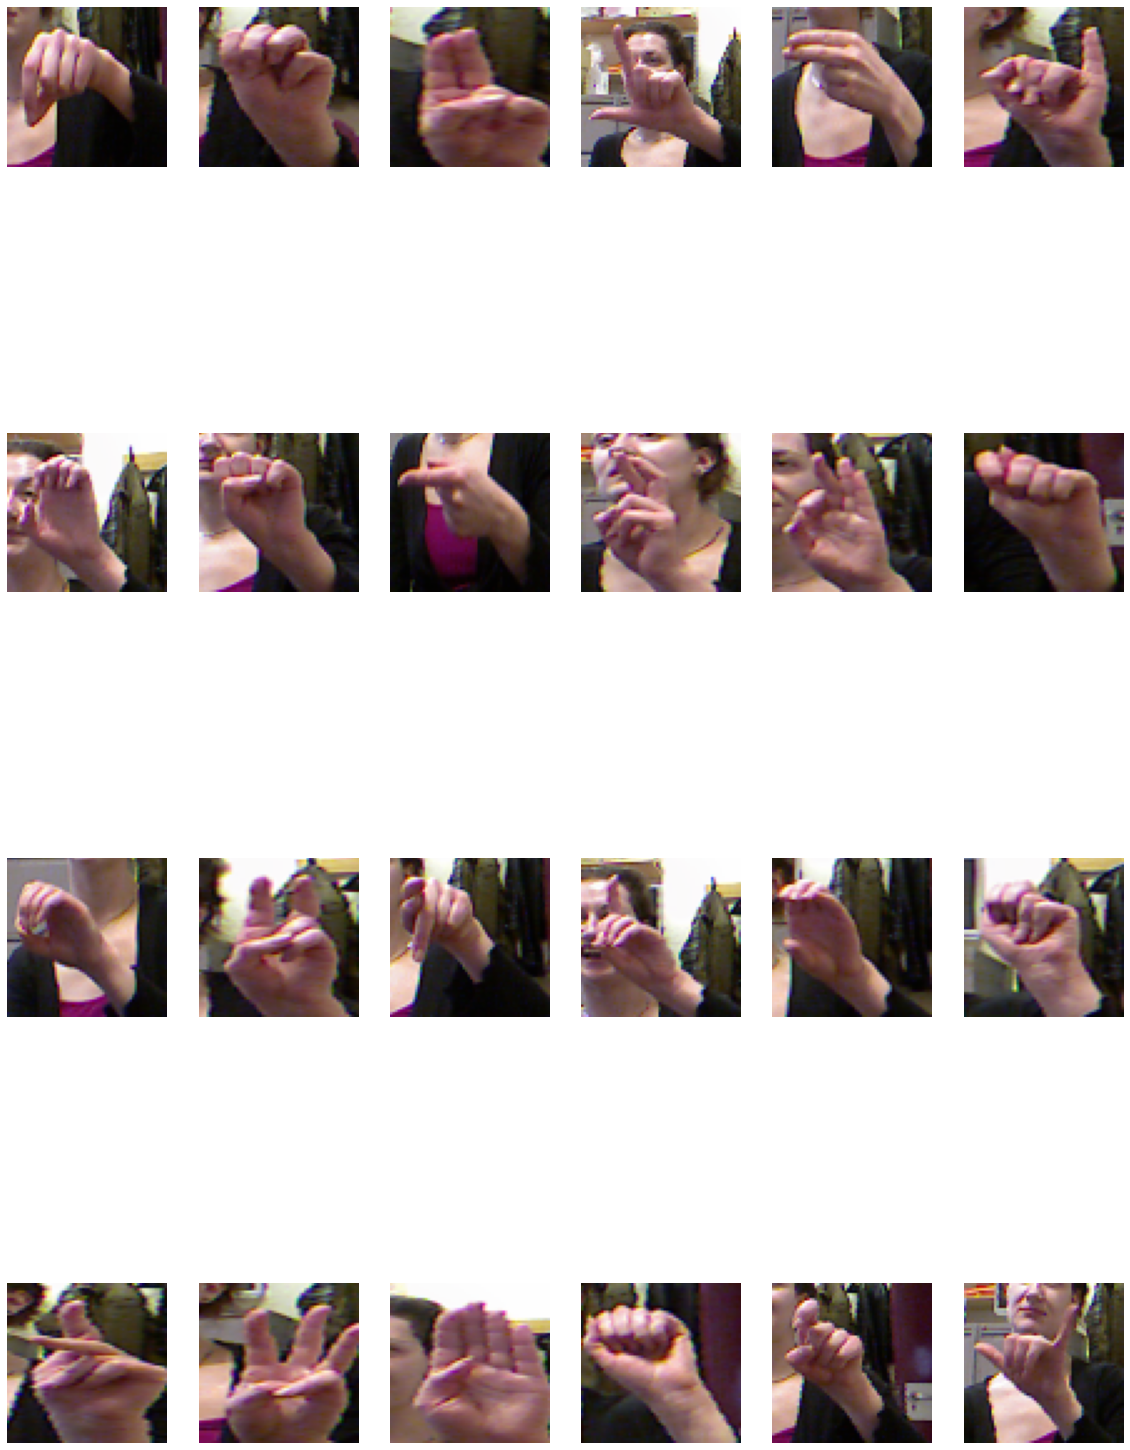

In [3]:
import matplotlib.pyplot as plt
import cv2


f, ax = plt.subplots(4,6, figsize = (20,30))

for i , (k, v) in enumerate(data_dict.items()):
    img = cv2.imread(v[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64,64))
    ax[i//6, i%6].imshow(img)
    ax[i//6, i%6].axis('off')

plt.show()

In [4]:
images = []
labels = []
for k,v in data_dict.items():
        for file in v:
            images.append(file)
            labels.append(k)

In [5]:
data_list = list(zip(images,labels))
data_df = pd.DataFrame(data_list, columns = ['Image', 'Label'])
data_df

Image Label
0      /kaggle/input/asl-rgb-depth-fingerspelling-spe...     q
1      /kaggle/input/asl-rgb-depth-fingerspelling-spe...     q
2      /kaggle/input/asl-rgb-depth-fingerspelling-spe...     q
3      /kaggle/input/asl-rgb-depth-fingerspelling-spe...     q
4      /kaggle/input/asl-rgb-depth-fingerspelling-spe...     q
...                                                  ...   ...
13388  /kaggle/input/asl-rgb-depth-fingerspelling-spe...     y
13389  /kaggle/input/asl-rgb-depth-fingerspelling-spe...     y
13390  /kaggle/input/asl-rgb-depth-fingerspelling-spe...     y
13391  /kaggle/input/asl-rgb-depth-fingerspelling-spe...     y
13392  /kaggle/input/asl-rgb-depth-fingerspelling-spe...     y

[13393 rows x 2 columns]

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

data = data_df.drop(columns = 'Label')


labels = data_df['Label']
lb = LabelBinarizer()
encoded_labels = lb.fit_transform(labels)


#shuffeling the data 
data, encoded_labels = shuffle(data, encoded_labels, random_state = 0)

X_train, X_test, y_train, y_test = train_test_split(data, encoded_labels, test_size = 0.25, random_state = 20)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10044, 1)
(10044, 24)
(3349, 1)
(3349, 24)


In [7]:
y_train[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0])

In [8]:
X_train['Image'][1:10]

11381    /kaggle/input/asl-rgb-depth-fingerspelling-spe...
3510     /kaggle/input/asl-rgb-depth-fingerspelling-spe...
9417     /kaggle/input/asl-rgb-depth-fingerspelling-spe...
7994     /kaggle/input/asl-rgb-depth-fingerspelling-spe...
6477     /kaggle/input/asl-rgb-depth-fingerspelling-spe...
1562     /kaggle/input/asl-rgb-depth-fingerspelling-spe...
10059    /kaggle/input/asl-rgb-depth-fingerspelling-spe...
4369     /kaggle/input/asl-rgb-depth-fingerspelling-spe...
3721     /kaggle/input/asl-rgb-depth-fingerspelling-spe...
Name: Image, dtype: object

In [9]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [10]:




def data_generator(data,encoded_labels, batch_size):
    num_samples = len(data)
    while True:

        for offset in range(0, num_samples, batch_size):
            batch_samples = data[offset: offset+batch_size]
            label_samples = encoded_labels[offset: offset+batch_size]
            X = []
            y = []
            for batch_sample in batch_samples:
                img_name = batch_sample[0]

                img = cv2.imread(str(img_name))
                img = cv2.resize(img, (128,128))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img.astype(np.float32)/255
                
                X.append(img)
            for label in label_samples:
                y.append(label)
                
                
                
            X = np.array(X)
            y = np.array(y)
            
            yield X, y

In [11]:
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, Dropout, Activation
from keras.models import Sequential
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape = (128, 128, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(24, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [12]:
bactsize = 40
train_data_gen = data_generator(data = X_train,encoded_labels = y_train, batch_size = bactsize)
val_data_gen = data_generator(data = X_test, encoded_labels = y_test, batch_size = bactsize)

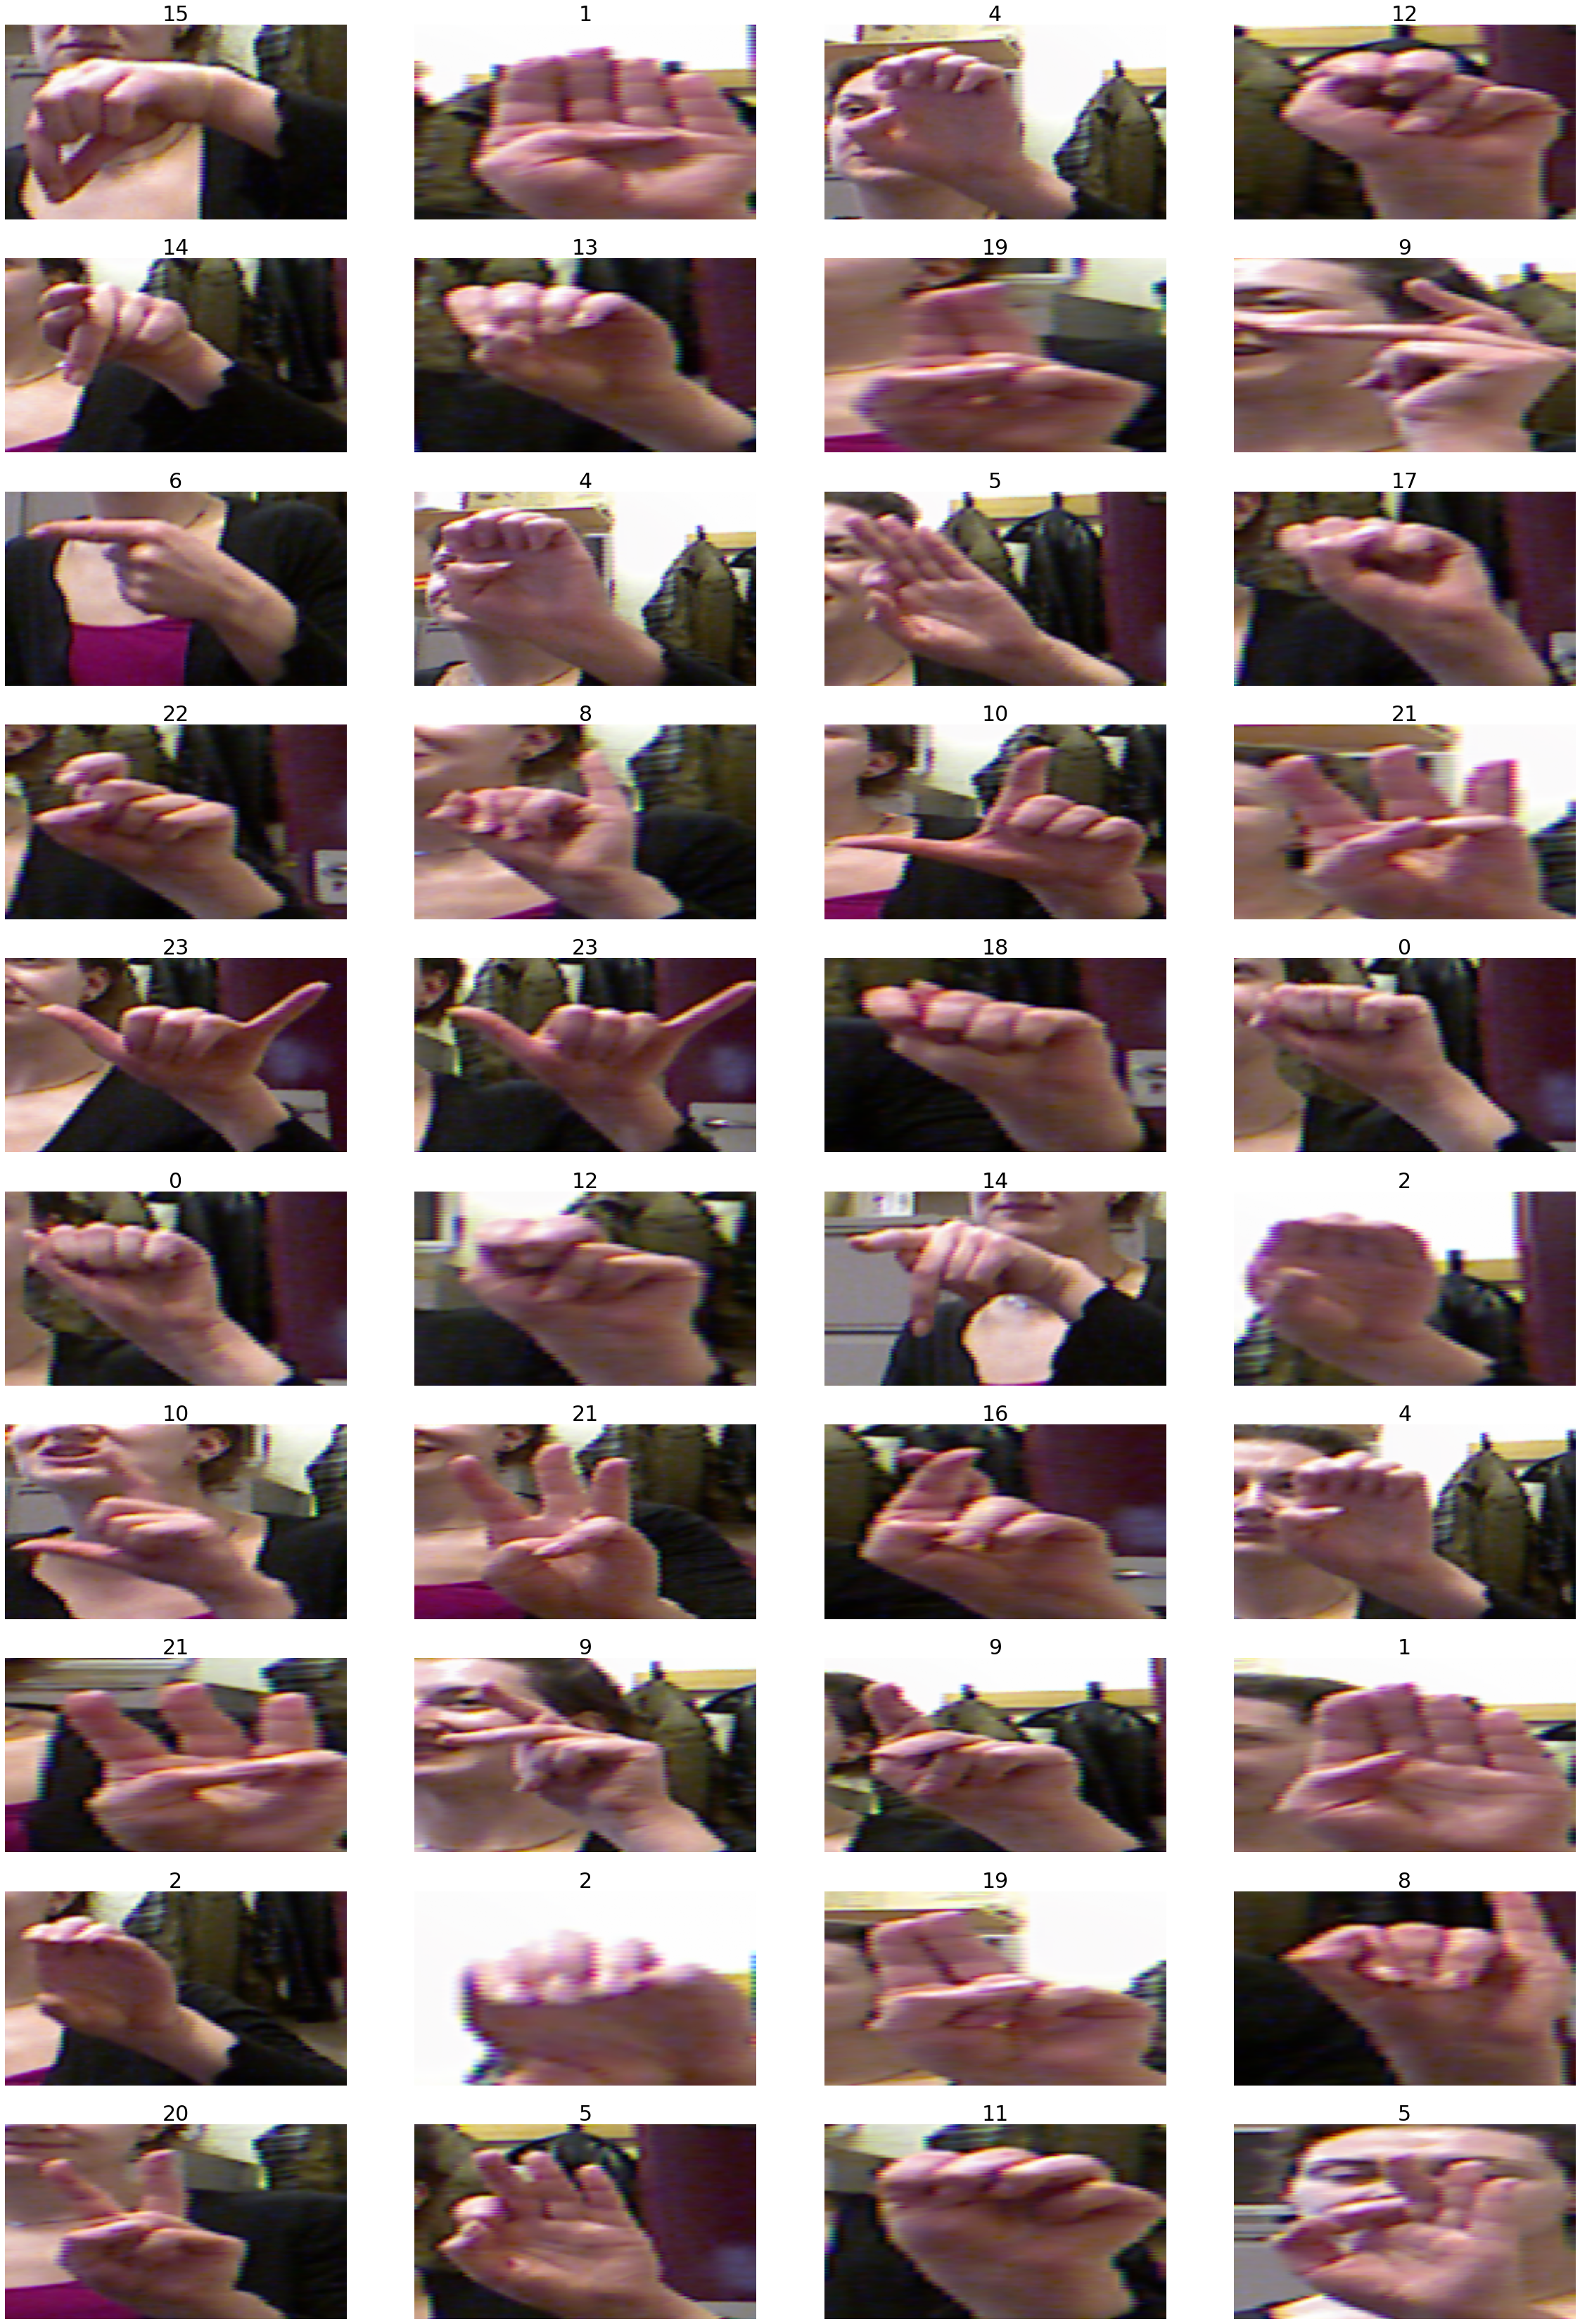

In [13]:
X_any, y_any = next(train_data_gen)
len(X_any)
len(y_any)
f, ax = plt.subplots(10,4, figsize = (40,60))
new_labels = []

for rows in y_any:
    row_max = np.argmax(rows)
    new_labels.append(row_max)



for i in range(40):
    
    img = X_any[i]    
    ax[i//4, i%4].imshow(img)
    ax[i//4, i%4].set_title(new_labels[i], fontsize = 30)
    
    ax[i//4, i%4].set_aspect('auto')
    ax[i//4, i%4].axis('off')
plt.show()
        

    
    
    

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopping = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(moniter = 'val_acc', patience = 10, verbose = 1, factor = 0.5,
                                           min_lr = 0.0001)
mycallbacks = [earlystopping, learning_rate_reduction]

In [15]:
total_train = X_train.shape[0]
total_val = X_test.shape[0]
validation_steps=total_val//bactsize
steps_per_epoch=total_train//bactsize
callbacks=mycallbacks

In [16]:
eph = 10
history = model.fit_generator(
    train_data_gen, 
    epochs=eph,
    validation_data=val_data_gen,
    validation_steps=total_val//bactsize,
    steps_per_epoch=total_train//bactsize,
    callbacks=mycallbacks
)

Epoch 1/10
251/251 [==============================] - 55s 219ms/step - loss: 0.4682 - accuracy: 0.8695 - val_loss: 13.9596 - val_accuracy: 0.1178 - lr: 0.0010
Epoch 2/10
251/251 [==============================] - 33s 129ms/step - loss: 0.0756 - accuracy: 0.9786 - val_loss: 5.5867 - val_accuracy: 0.3217 - lr: 0.0010
Epoch 3/10
251/251 [==============================] - 32s 126ms/step - loss: 0.0309 - accuracy: 0.9922 - val_loss: 2.0561 - val_accuracy: 0.6614 - lr: 0.0010
Epoch 4/10
251/251 [==============================] - 32s 126ms/step - loss: 0.0167 - accuracy: 0.9956 - val_loss: 0.0403 - val_accuracy: 0.9892 - lr: 0.0010
Epoch 5/10
251/251 [==============================] - 32s 129ms/step - loss: 0.0124 - accuracy: 0.9964 - val_loss: 0.4766 - val_accuracy: 0.8654 - lr: 0.0010
Epoch 6/10
251/251 [==============================] - 31s 125ms/step - loss: 0.0064 - accuracy: 0.9983 - val_loss: 1.5437 - val_accuracy: 0.6919 - lr: 0.0010
Epoch 7/10
251/251 [==============================]

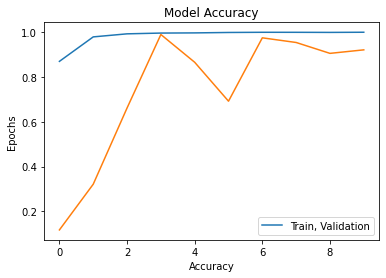

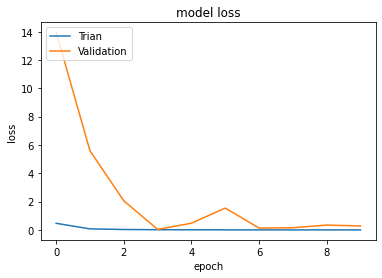

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Epochs')
plt.xlabel('Accuracy')
plt.legend(['Train, Validation'], loc = 'best')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Trian', 'Validation'], loc='upper left')
plt.show()

(128, 128, 3)

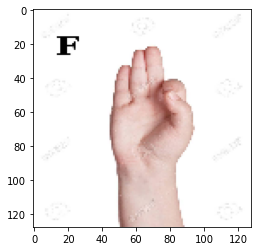

In [18]:
custom_img_dir = Path('../input/testimage/')
img_dir = os.listdir(custom_img_dir)
img = cv2.imread(os.path.join(custom_img_dir, img_dir[0]))
img = cv2.resize(img, (128,128))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.astype(np.float32)/255
custom_img = np.array(img)
plt.imshow(custom_img)
custom_img.shape

In [19]:
img_list = []
img_list.append(custom_img)
img_list = np.array(img_list)
img_list.shape

(1, 128, 128, 3)

In [20]:
pred = model.predict_proba(img_list)
pred = np.argmax(pred)
pred

1